# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

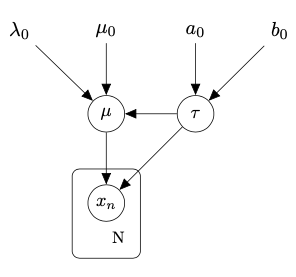

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [76]:
import numpy as np
from scipy.stats import gamma, norm
from scipy.special import psi
np.random.seed(14)

def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, 1/tau, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



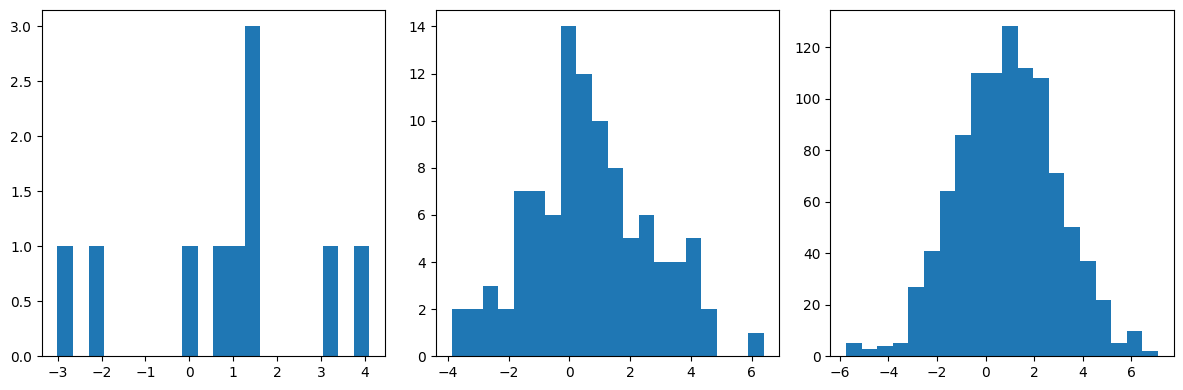

In [77]:
MU = 1
TAU = 0.5

dataset_1 = generate_data(MU, TAU, 10)
dataset_2 = generate_data(MU, TAU, 100)
dataset_3 = generate_data(MU, TAU, 1000)

# Visulaize the datasets via histograms
# Insert your code here
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(dataset_1, bins=20)
axs[1].hist(dataset_2, bins=20)
axs[2].hist(dataset_3, bins=20)
plt.tight_layout()
plt.savefig('12_data.png')
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [78]:
def ML_est(data):
    # insert your code
    N = len(data)
    x_mean = np.mean(data)
    x_var = np.var(data, ddof=1)

    tau_ml = 1 / x_var
    mu_ml = x_mean

    return mu_ml, tau_ml

### ***Question 1.3.14:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [79]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    x_mean = np.mean(D)
    N = len(D)

    mu_prime = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
    lambda_prime = lambda_0 + N
    a_prime = a_0 + N / 2
    b_prime = b_0 + 0.5 * (np.sum(D**2) +
                             lambda_0 * mu_0**2 - lambda_prime * mu_prime**2)

    exact_post_distribution = (a_prime, b_prime, mu_prime, lambda_prime)

    return exact_post_distribution

In [80]:
# prior parameters
mu_0 = 0
lambda_0 = 10
a_0 = 20
b_0 = 20

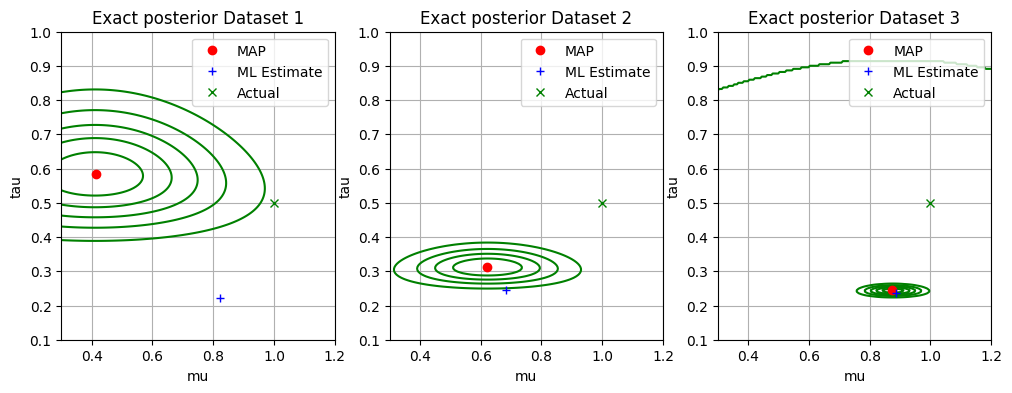

In [81]:
mus = np.linspace(0.3, 1.2, 200)
taus = np.linspace(0.1, 1, 200)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, dataset in enumerate([dataset_1, dataset_2, dataset_3]):
  mu_ml, tau_ml = ML_est(dataset)

  a_T, b_T, mu_T, lambda_T = compute_exact_posterior(
      dataset, a_0, b_0, mu_0, lambda_0)

  Z_exact = np.zeros((len(mus), len(taus)))
  pTau = gamma(a=a_T, loc=0, scale=1/b_T)
  for j, tau in enumerate(taus):
      pMu = norm(loc=mu_T, scale=1/np.sqrt(lambda_T*tau))
      Z_exact[:, j] = pMu.pdf(mus) * pTau.pdf(tau)
  # Finding the maximum of the exact posterior
  mu_max_exact = mus[np.argmax(np.max(Z_exact, axis=1))]
  tau_max_exact = taus[np.argmax(np.max(Z_exact, axis=0))]
  # Plotting the results
  axs[i].contour(*np.meshgrid(mus, taus), Z_exact.T,
                 levels=5, colors=['green'])
  axs[i].plot(mu_max_exact, tau_max_exact, 'ro', label='MAP')
  axs[i].plot(mu_ml, tau_ml, 'b+', label='ML Estimate')
  axs[i].plot(MU, TAU, 'gx', label='Actual')
  axs[i].legend()
  axs[i].grid()
  axs[i].set_xlabel('mu')
  axs[i].set_ylabel('tau')
  axs[i].set_title('Exact posterior Dataset {}'.format(i+1))

plt.savefig('14_contours.png')
plt.show()

### ***Question 1.3.15:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

Continue with a helper function that computes ELBO:


In [82]:
eps = 1e-6

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)
    x_mean = np.mean(D)
    x_2_sum = np.sum(D**2)

    # compute the elbo

    return elbo

Now, implement the CAVI algorithm:

In [83]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, iter=5):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = 1

  N = len(D)
  x_mean = np.mean(D)
  x_2_sum = np.sum(D**2)

  # Constants
  a_N = a_0 + N / 2
  mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
  E_mu = mu_N
  
  # Variational parameters
  b_N = b_0
  lambda_N = (lambda_0 + N) * initial_guess_exp_tau

  b_Ns = [b_N]
  lambda_Ns = [lambda_N]

  # ELBO
  elbos = []

  # CAVI iterations ...
  for i in range(iter):
    # update the values for the variational parameters
    E_tau = a_N / b_N 
    E_mu_2 = 1 / lambda_N + mu_N**2

    lambda_N = (lambda_0 + N) * E_tau
    b_N = b_0 + 0.5 * (x_2_sum + N*E_mu_2 - 2*N*E_mu*x_mean + lambda_0*(E_mu_2 - 2*E_mu*mu_0 + mu_0**2))

    b_Ns.append(b_N)
    lambda_Ns.append(lambda_N)
    # save ELBO for each iteration, plot them afterwards to show convergence
    #elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

  return a_N, b_N, mu_N, lambda_N, elbos, b_Ns, lambda_Ns

### ***Question 1.3.15:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



In [84]:
def compute_z(mus, taus, a_, b_, mu_, lambda_):
    z = np.zeros((len(mus), len(taus)))
    pTau = gamma(a=a_, loc=0, scale=1/b_)
    for j, tau in enumerate(taus):
        pMu = norm(loc=mu_, scale=1/np.sqrt(lambda_*tau))
        z[:, j] = pMu.pdf(mus) * pTau.pdf(tau)

    return z

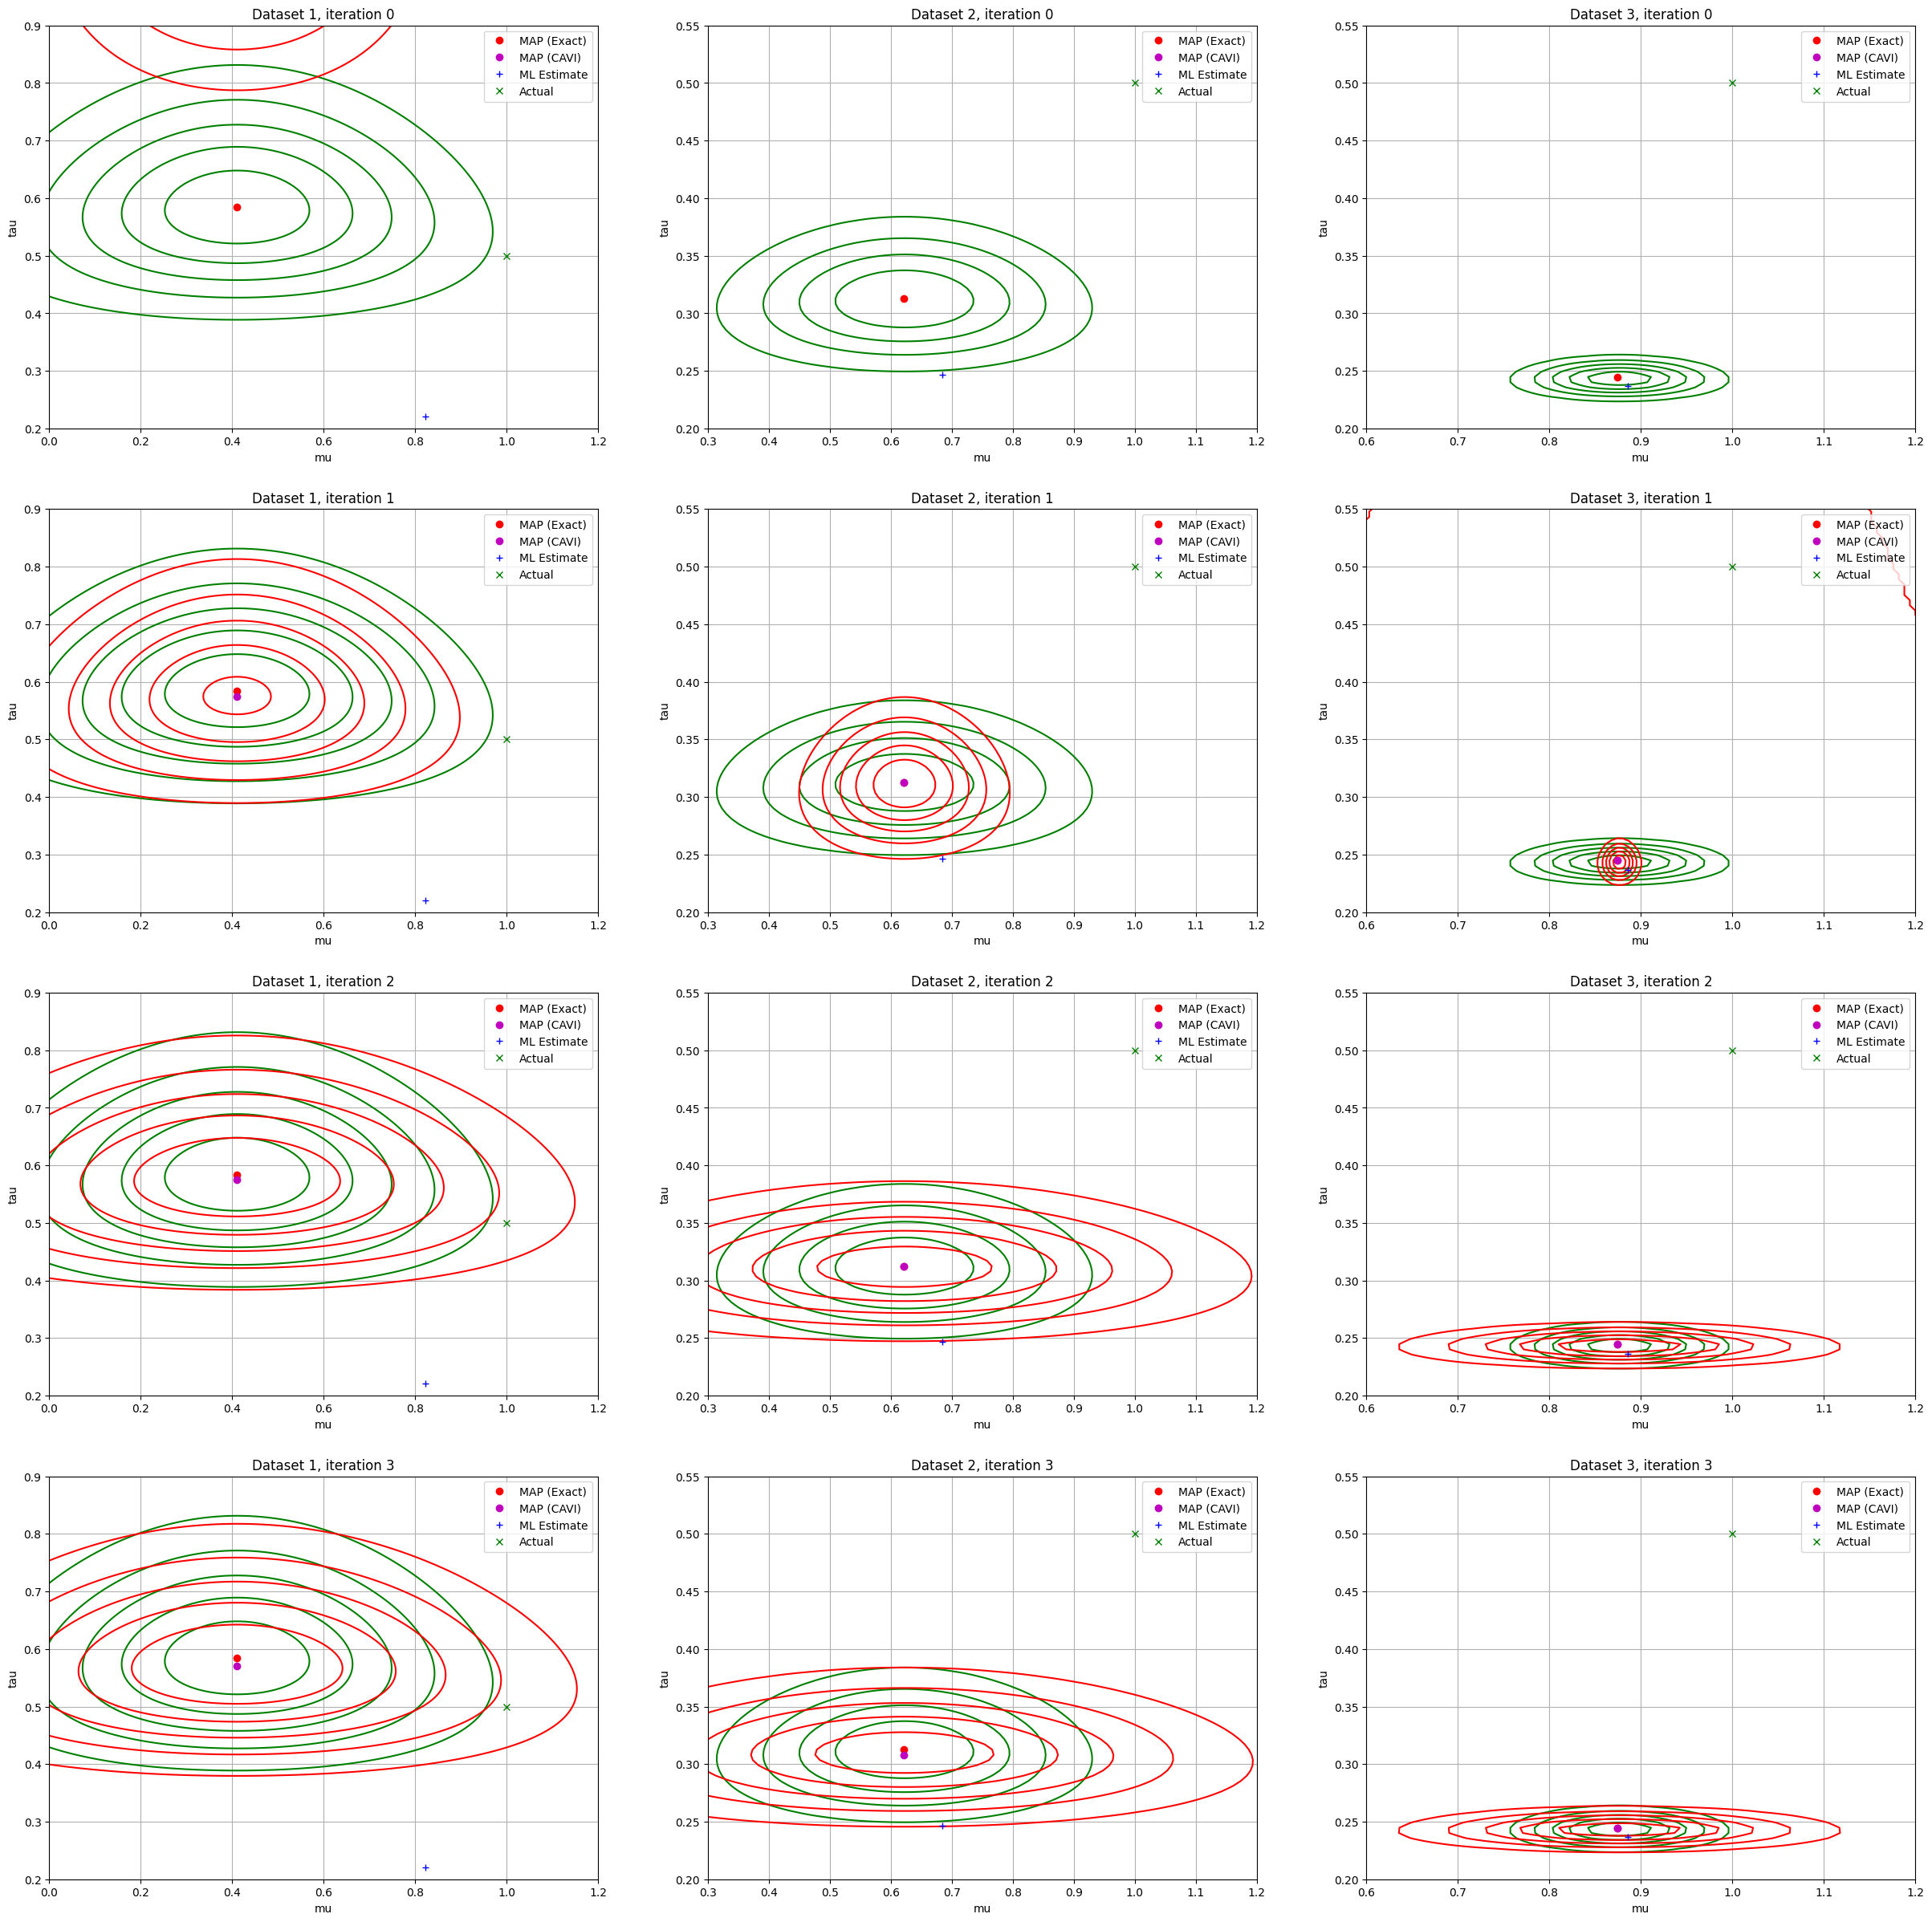

In [85]:
# Insert your main code here
iter = 3 # number of iterations for CAVI
mus = np.linspace(0, 1.2, 200)
taus = np.linspace(0.1, 1, 200)

xlims = [[0, 1.2], [0.3, 1.2], [0.6, 1.2]]
ylims = [[0.2, 0.9], [0.2, 0.55], [0.2, 0.55]]

fig, axs = plt.subplots(iter+1, 3, figsize=(30, 30))
for i, dataset in enumerate([dataset_1, dataset_2, dataset_3]):
  mu_ml, tau_ml = ML_est(dataset)
  a_N, b_N, mu_N, lambda_N, elbos, b_Ns, lambda_Ns = CAVI(dataset, a_0, b_0, mu_0, lambda_0, iter=iter)
  a_T, b_T, mu_T, lambda_T = compute_exact_posterior(
      dataset, a_0, b_0, mu_0, lambda_0)

  for j in range(iter+1):
    Z_exact = compute_z(mus, taus, a_T, b_T, mu_T, lambda_T)
    Z_cavi = compute_z(mus, taus, a_N, b_Ns[j], mu_N, lambda_Ns[j])
    # Finding the maximum of the exact posterior
    mu_max_exact = mus[np.argmax(np.max(Z_exact, axis=1))]
    tau_max_exact = taus[np.argmax(np.max(Z_exact, axis=0))]
    # Finding the maximum of the CAVI approximation
    mu_max_cavi = mus[np.argmax(np.max(Z_cavi, axis=1))]
    tau_max_cavi = taus[np.argmax(np.max(Z_cavi, axis=0))]
    # Plotting the results
    axs[j, i].contour(*np.meshgrid(mus, taus), Z_exact.T,
                  levels=5, colors=['green'])
    axs[j, i].contour(*np.meshgrid(mus, taus), Z_cavi.T,
                    levels=5, colors=['red'])
    axs[j, i].plot(mu_max_exact, tau_max_exact, 'ro', label='MAP (Exact)')
    axs[j, i].plot(mu_max_cavi, tau_max_cavi, 'mo', label='MAP (CAVI)')
    axs[j, i].plot(mu_ml, tau_ml, 'b+', label='ML Estimate')
    axs[j, i].plot(MU, TAU, 'gx', label='Actual')
    axs[j, i].legend()
    axs[j, i].grid()
    axs[j, i].set_xlabel('mu')
    axs[j, i].set_ylabel('tau')
    axs[j, i].set_title(f'Dataset {i+1}, iteration {j}')
    axs[j, i].set_xlim(xlims[i])
    axs[j, i].set_ylim(ylims[i])

plt.savefig('15_contours.png')
plt.show()


# Plot ELBOs
#plt.plot(elbos)
#plt.xlabel('Iterations')
#plt.ylabel('ELBO')
#plt.savefig('elbo.png')
#plt.show()
